# NBA All-star by Smashmouth
## Created by William Parlan and Aaron Miller
### CPSC 322, Spring 2022

# Introduction

## Dataset Overview  
We used a dataset built from the Per Game and Advanced statistics pages from [Basketball Reference](https://www.basketball-reference.com/leagues/NBA_2021_per_game.html).  
The dataset contains both unprocessed statistics (Points, Steals, Assists), and calculated statistics (Effective Field Goal Percentage, Win Shares, Value Over Replacement Player).  
This provides a dichotomy between the raw and processed statistics and how each may be better or worse at predictions.
## Summary of Findings
As of this writing, Naive Bayes is the most accurate classifier. It predicts the correct class label with 85.1% accuracy.  
This is followed in order by Decision Tree, KNN, and Dummy classifiers with 84.1%, 79.3%, 75.2% repsectively. 

# Data Analysis

## Attributes Explained
#### Source: [Basketball Reference](https://www.basketball-reference.com/leagues/NBA_2021_per_game.html)
#### Format: CSV or excel spreadsheet  
#### Contents:  
|Attribute|Name in Dataset|Description|
|--|--|--|
|Field Goal Percentage|FG%|Field Goals scored / Field Goals Attempted
|3-Point Field Goal Percentage|3P%|3-point Field Goal scored / Attempted
|Effective Field Goal Percentage|eFG|Field Goal Percentage adjusted by the fact that 3-Point Field Goals are worth one more point than 2-point goals
|Total Rebounds|TRB|Combined total of offensive and defensive rebounds
|Assists|AST|Number of Assists
|Steals|STL|Number of Steals
|Blocks|BLK|Number of Blocks
|Points|PTS|Points Scored
|Player Efficiency Rating|PER|A measure of per-minute production standardized such that the league average is 15
|True Shooting Percentage|TS%|A measure of shooting efficency that takes into account 2-point field goals, 3-point field goals and free throws
|Win Shares|WS|An estimate of the number of wins contributed by a player
|Box Plus Minus|DBPM|A box score estimate of the points per 100 possesions a player contributed above a league-average player, translated to an average team
|Value Over Replacement Player|VORP|A box score estimate of the points per 100 TEAM possesions that a player contributed above a replacement-level (-2.0) player, translated to an average team and prorated to an 82-game season. Multiply by 2.70 to convert to wins over replacement
|All-star|All-star|Binary classification we are trying to predict

## Summary Statistics
Number of Instances: 517  
Number of Instances with Positive Class Label (yes): 128  
Number of Instances with Negative Class Label (no): 388


# Code Setup

## Import libraries and packages

In [328]:
# some useful mysklearn package import statements and reloads
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

from os import path
import utils
importlib.reload(utils)
import plot_utils
importlib.reload(plot_utils)

<module 'plot_utils' from '/home/NBA-All-Star-CPSC-322/plot_utils.py'>

## Data Import and Setup

In [329]:
filename = path.join('input_data', 'AllStarData.csv')
basketball_data = MyPyTable().load_from_file(filename)

## Win Shares Histogram

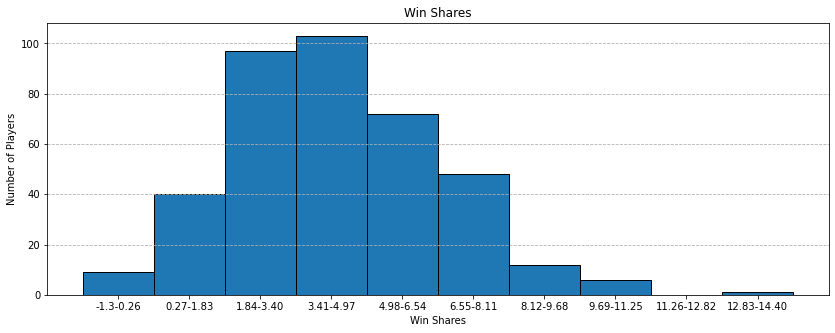

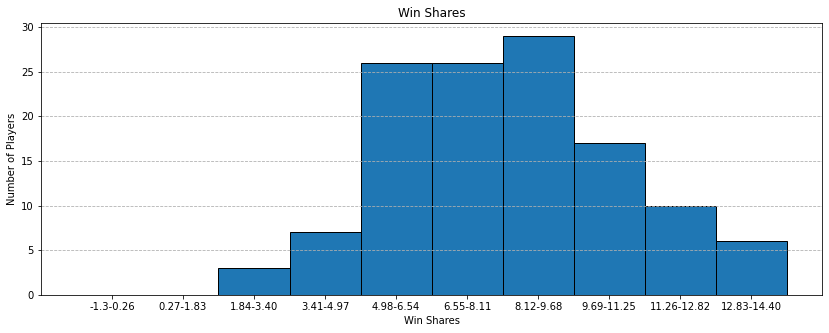

In [330]:
# retrieve data from table
win_shares = []
allstar_ws = []
for row in basketball_data.data:
    if row[-1] == 'no':
        win_shares.append(row[10])
    else:
        allstar_ws.append(row[10])
# build cutoffscutoffs = utils.compute_equal_width_cutoffs(win_shares, 10)
cutoffs = utils.compute_equal_width_cutoffs(win_shares, 10)
ws_freqs = utils.compute_bin_frequencies(win_shares, cutoffs)
allstar_ws_freqs = utils.compute_bin_frequencies(allstar_ws, cutoffs)
x_axis = []
for i in range(len(cutoffs)-2):
    x_axis.append(f"{cutoffs[i]}-{format(cutoffs[i+1]-0.01, '.2f')}")
x_axis.append(f"{cutoffs[i+1]}-{format(cutoffs[i+2], '.2f')}")
plot_utils.bar_chart(x_axis, ws_freqs, 'Win Shares', 'Win Shares', 'Number of Players', grouped=True)
plot_utils.bar_chart(x_axis, allstar_ws_freqs, 'Win Shares', 'Win Shares', 'Number of Players', grouped=True)

# Classification Results

## Classifier Setup

In [331]:
# set up classifiers
knn_classifier = MyKNeighborsClassifier(n_neighbors=10)
dummy_classifier = MyDummyClassifier()
nb_classifier = MyNaiveBayesClassifier()
decision_tree = MyDecisionTreeClassifier()
classifiers = [knn_classifier, dummy_classifier, nb_classifier, decision_tree]
# Other vars
RANDOM_STATE = 6

## Discretize Data

In [332]:
# convert the values by column
discrete_columns = []
for index in range(len(basketball_data.column_names)-1):
    curr_column = basketball_data.get_column(index, False)
    cutoffs = utils.compute_equal_width_cutoffs(curr_column, 10)
    output = myutils.create_output_for_discrete(curr_column, 10)
    new_column = [myutils.discretize_ratings_custom(val, cutoffs, output) for val in curr_column]
    discrete_columns.append(new_column)
# now that the columns are converted, we convert them to rows
discrete_data = []
allstar_counter = 0
for column_index in range(len(discrete_columns[0])):
    new_row = []
    for row_index in range(len(discrete_columns)):
        try:
            new_row.append(discrete_columns[row_index][column_index])
        except IndexError:
            continue
    new_row.append(basketball_data.data[allstar_counter][-1])
    allstar_counter += 1
    discrete_data.append(new_row)

## Predict Using Effective Field Goal Percentage (eFG%)

In [333]:
# retrieve data from table
efg_data = [row[2] for row in discrete_data]
allstars = [row[-1] for row in discrete_data]
# build train and test sets
train_sets, test_sets = myevaluation.stratified_kfold_cross_validation(efg_data, allstars, n_splits=10,random_state=RANDOM_STATE)
test_length = 0
test_answers = []
for test in test_sets: 
    test_answers += [allstars[index] for index in test]
    test_length += len(test)
# run tests and record results
classifier_results = []
for classifier in classifiers:
    result_set = [[], 0] # [all the predictions, total_number_true] 
    for train, test in zip(train_sets, test_sets):
        # convert the indices to actual samples
        x_train = [[efg_data[index]] for index in train]
        y_train = [allstars[index] for index in train]
        x_test = [[efg_data[index]] for index in test]
        y_test = [allstars[index] for index in test]
        # fit and predict
        classifier.fit(x_train, y_train)
        prediction = classifier.predict(x_test)
        num_true = myevaluation.accuracy_score(y_test, prediction, normalize=False)
        # update counters
        result_set[0] += prediction
        result_set[1] += num_true
    # finalize results
    result_set[1] /= test_length
    classifier_results.append(result_set)

## Output Results

In [334]:
classifier_names = ['KNN', 'Dummy', 'Naive Bayes', 'Decision Tree']
headers = ['no', 'yes']
myevaluation.print_classifier_results(classifier_names, classifier_results, test_answers, headers)

KNN--------------------------
Summary:
	Accuracy..: 0.744
	Error Rate: 0.256 

Precision, Recall, F1:
       precision    recall         f1    support
---  -----------  --------  ---------  ---------
yes     0.333333  0.03125   0.0571429        128
no      0.753968  0.979381  0.852018         388 

Confusion Matrix:
       no    yes    Total    Recognition (%)
---  ----  -----  -------  -----------------
no    380      8      388             97.938
yes   124      4      128              3.125


Dummy--------------------------
Summary:
	Accuracy..: 0.752
	Error Rate: 0.248 

Precision, Recall, F1:
       precision    recall        f1    support
---  -----------  --------  --------  ---------
yes     0                0  0               128
no      0.751938         1  0.858407        388 

Confusion Matrix:
       no    yes    Total    Recognition (%)
---  ----  -----  -------  -----------------
no    388      0      388                100
yes   128      0      128                  0


Na

## Effective Field Goal Percentage
The ultimate challenge for every classifier is to beat 75.2% accuracy of the Dummy classifier.  
This data is mostly one of two options and that means Dummy is mostly correct.  

And no classifier is able to do it.  
It's a tie for the silver medal as both Naive Bayes and KNN produce a 74.4% accurate predictions.  
This leaves bronze to Decision Tree with 74%, just 0.4% less than silver.  

## More Traits

In [335]:
multi_trait_data = [[row[3], row[4], row[5], row[6], row[7]] for row in discrete_data]
# build train and test sets
train_sets, test_sets = myevaluation.stratified_kfold_cross_validation(multi_trait_data, allstars, n_splits=10,random_state=RANDOM_STATE)
test_length = 0
test_answers = []
for test in test_sets: 
    test_answers += [allstars[index] for index in test]
    test_length += len(test)
# run tests and record results
classifier_results = []
for classifier in classifiers:
    result_set = [[], 0] # [all the predictions, total_number_true] 
    for train, test in zip(train_sets, test_sets):
        # convert the indices to actual samples
        x_train = [multi_trait_data[index] for index in train]
        y_train = [allstars[index] for index in train]
        x_test = [multi_trait_data[index] for index in test]
        y_test = [allstars[index] for index in test]
        # fit and predict
        classifier.fit(x_train, y_train)
        prediction = classifier.predict(x_test)
        num_true = myevaluation.accuracy_score(y_test, prediction, normalize=False)
        # update counters
        result_set[0] += prediction
        result_set[1] += num_true
    # finalize results
    result_set[1] /= test_length
    classifier_results.append(result_set)

In [336]:
classifier_names = ['KNN', 'Dummy', 'Naive Bayes', 'Decision Tree']
headers = ['no', 'yes']
myevaluation.print_classifier_results(classifier_names, classifier_results, test_answers, headers)

KNN--------------------------
Summary:
	Accuracy..: 0.793
	Error Rate: 0.207 

Precision, Recall, F1:
       precision    recall        f1    support
---  -----------  --------  --------  ---------
yes     0.744186  0.25      0.374269        128
no      0.79704   0.971649  0.875726        388 

Confusion Matrix:
       no    yes    Total    Recognition (%)
---  ----  -----  -------  -----------------
no    377     11      388             97.165
yes    96     32      128             25


Dummy--------------------------
Summary:
	Accuracy..: 0.752
	Error Rate: 0.248 

Precision, Recall, F1:
       precision    recall        f1    support
---  -----------  --------  --------  ---------
yes     0                0  0               128
no      0.751938         1  0.858407        388 

Confusion Matrix:
       no    yes    Total    Recognition (%)
---  ----  -----  -------  -----------------
no    388      0      388                100
yes   128      0      128                  0


Naive Baye

## Multi Trait Classification Results
### These results are great!
Dummy has retaken its rightful place as the worst classifier.  
Naive Bayes wins with an accuracy of 85.1%, followed by Decision Tree with 84.1% accuracy.  
Next is KNN with 79.3% and lastly Dummy with 75.2% accuracy.  

This means that these classifiers are proven to be better than pure guessing! Hooray!

## Only the 'Advanced' Stats

In [337]:
advanced_data = [[row[2], row[8], row[9], row[10], row[11], row[12]] for row in discrete_data]
# build train and test sets
train_sets, test_sets = myevaluation.stratified_kfold_cross_validation(advanced_data, allstars, n_splits=10,random_state=RANDOM_STATE)
test_length = 0
test_answers = []
for test in test_sets: 
    test_answers += [allstars[index] for index in test]
    test_length += len(test)
# run tests and record results
classifier_results = []
for classifier in classifiers:
    result_set = [[], 0] # [all the predictions, total_number_true] 
    for train, test in zip(train_sets, test_sets):
        # convert the indices to actual samples
        x_train = [advanced_data[index] for index in train]
        y_train = [allstars[index] for index in train]
        x_test = [advanced_data[index] for index in test]
        y_test = [allstars[index] for index in test]
        # fit and predict
        classifier.fit(x_train, y_train)
        prediction = classifier.predict(x_test)
        num_true = myevaluation.accuracy_score(y_test, prediction, normalize=False)
        # update counters
        result_set[0] += prediction
        result_set[1] += num_true
    # finalize results
    result_set[1] /= test_length
    classifier_results.append(result_set)

In [338]:
classifier_names = ['KNN', 'Dummy', 'Naive Bayes', 'Decision Tree']
headers = ['no', 'yes']
myevaluation.print_classifier_results(classifier_names, classifier_results, test_answers, headers)

KNN--------------------------
Summary:
	Accuracy..: 0.866
	Error Rate: 0.134 

Precision, Recall, F1:
       precision    recall        f1    support
---  -----------  --------  --------  ---------
yes     0.775701  0.648438  0.706383        128
no      0.889976  0.938144  0.913425        388 

Confusion Matrix:
       no    yes    Total    Recognition (%)
---  ----  -----  -------  -----------------
no    364     24      388             93.814
yes    45     83      128             64.844


Dummy--------------------------
Summary:
	Accuracy..: 0.752
	Error Rate: 0.248 

Precision, Recall, F1:
       precision    recall        f1    support
---  -----------  --------  --------  ---------
yes     0                0  0               128
no      0.751938         1  0.858407        388 

Confusion Matrix:
       no    yes    Total    Recognition (%)
---  ----  -----  -------  -----------------
no    388      0      388                100
yes   128      0      128                  0


Naive 

## Advanced Attribute Analysis
KNN becomes the most accurate with an astouding 86.6% accuracy.  
The rest of the crew is about the same, Naive Bayes followed by Decision Tree, followed by Dummy in last.


## All the Attributes!

In [339]:
all_data = [[row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9], row[10], row[11], row[12]] for row in discrete_data]
# build train and test sets
train_sets, test_sets = myevaluation.stratified_kfold_cross_validation(all_data, allstars, n_splits=10,random_state=RANDOM_STATE)
test_length = 0
test_answers = []
for test in test_sets: 
    test_answers += [allstars[index] for index in test]
    test_length += len(test)
# run tests and record results
classifier_results = []
for classifier in classifiers:
    result_set = [[], 0] # [all the predictions, total_number_true] 
    for train, test in zip(train_sets, test_sets):
        # convert the indices to actual samples
        x_train = [all_data[index] for index in train]
        y_train = [allstars[index] for index in train]
        x_test = [all_data[index] for index in test]
        y_test = [allstars[index] for index in test]
        # fit and predict
        classifier.fit(x_train, y_train)
        prediction = classifier.predict(x_test)
        num_true = myevaluation.accuracy_score(y_test, prediction, normalize=False)
        # update counters
        result_set[0] += prediction
        result_set[1] += num_true
    # finalize results
    result_set[1] /= test_length
    classifier_results.append(result_set)

In [340]:
classifier_names = ['KNN', 'Dummy', 'Naive Bayes', 'Decision Tree']
headers = ['no', 'yes']
myevaluation.print_classifier_results(classifier_names, classifier_results, test_answers, headers)

KNN--------------------------
Summary:
	Accuracy..: 0.86
	Error Rate: 0.14 

Precision, Recall, F1:
       precision    recall        f1    support
---  -----------  --------  --------  ---------
yes     0.78      0.609375  0.684211        128
no      0.879808  0.943299  0.910448        388 

Confusion Matrix:
       no    yes    Total    Recognition (%)
---  ----  -----  -------  -----------------
no    366     22      388             94.33
yes    50     78      128             60.938


Dummy--------------------------
Summary:
	Accuracy..: 0.752
	Error Rate: 0.248 

Precision, Recall, F1:
       precision    recall        f1    support
---  -----------  --------  --------  ---------
yes     0                0  0               128
no      0.751938         1  0.858407        388 

Confusion Matrix:
       no    yes    Total    Recognition (%)
---  ----  -----  -------  -----------------
no    388      0      388                100
yes   128      0      128                  0


Naive Bay

## All Traits Analysis
KNN takes the lead! KNN has 86% accuracy! With enough data to refer against, or some combination of traits therein, KNN makes the most accurate predictions.  
Naive Bayes is second just 0.3% less accurate than KNN, and takes second.
Decision Tree does uncharateristically poor, with 81.8%.  
Dummy comes up last, as expected.

Interestingly, this is not the most accurate data set. The previous dataset, (only advanced stats) does barely better, but that could be due to random variance.